<a href="https://colab.research.google.com/github/berberberk/timl-fs-2024/blob/main/TIMO6_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек и данных

In [1]:
import kagglehub

#kagglehub.login()

In [309]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.stats import stattools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN

In [3]:

# Download latest version
path = kagglehub.dataset_download("uom190346a/sleep-health-and-lifestyle-dataset", path='Sleep_health_and_lifestyle_dataset.csv')

print("Path to dataset files:", path)

100%|██████████| 23.6k/23.6k [00:00<00:00, 16.0MB/s]

Path to dataset files: /root/.cache/kagglehub/datasets/uom190346a/sleep-health-and-lifestyle-dataset/versions/2/Sleep_health_and_lifestyle_dataset.csv


Dataset Columns:

Person ID: An identifier for each individual.

Gender: The gender of the person (Male/Female).

Age: The age of the person in years.

Occupation: The occupation or profession of the person.

Sleep Duration (hours): The number of hours the person sleeps per day.

Quality of Sleep (scale: 1-10): A subjective rating of the quality of sleep, ranging from 1 to 10.

Physical Activity Level (minutes/day): The number of minutes the person engages in physical activity daily.

Stress Level (scale: 1-10): A subjective rating of the stress level experienced by the person, ranging from 1 to 10.

BMI Category: The BMI category of the person (e.g., Underweight, Normal, Overweight).

Blood Pressure (systolic/diastolic): The blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure.

Heart Rate (bpm): The resting heart rate of the person in beats per minute.
Daily Steps: The number of steps the person takes per day.

Sleep Disorder: The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea)

In [180]:
df = pd.read_csv(path)
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


## EDA + Предобработка данных

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [182]:
df.isnull().sum()

,0
Person ID,0
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Blood Pressure,0


In [183]:
df['Sleep Disorder'].unique()

array([nan, 'Sleep Apnea', 'Insomnia'], dtype=object)

In [184]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('Normal')

In [185]:
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic'] = df['Systolic'].astype(int)
df['Diastolic'] = df['Diastolic'].astype(int)


## def classify_bp(row):
##     if row['Systolic'] < 120 and row['Diastolic'] < 80:
##         return 'Normal'
##     elif 120 <= row['Systolic'] < 130 and row['Diastolic'] < 80:
##         return 'Elevated'
##     elif 130 <= row['Systolic'] < 140 or 80 <= row['Diastolic'] < 90:
##         return 'Hypertension Stage1'
##     else:
##         return 'Hypertension Stage2'
##
## df['BP Category'] = df.apply(classify_bp, axis=1)

In [186]:
df.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920,128.553476,84.649733
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679,7.748118,6.161611
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000,115.000000,75.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000,125.000000,80.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000,130.000000,85.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000,135.000000,90.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000,142.000000,95.000000


In [187]:
df.set_index("Person ID", inplace=True)
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
Person ID,,,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,Normal,126,83
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Normal,125,80
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Normal,125,80
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140,90
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea,140,95
371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea,140,95
372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea,140,95


Text(0.5, 1.0, 'Age vs Sleep Duration')

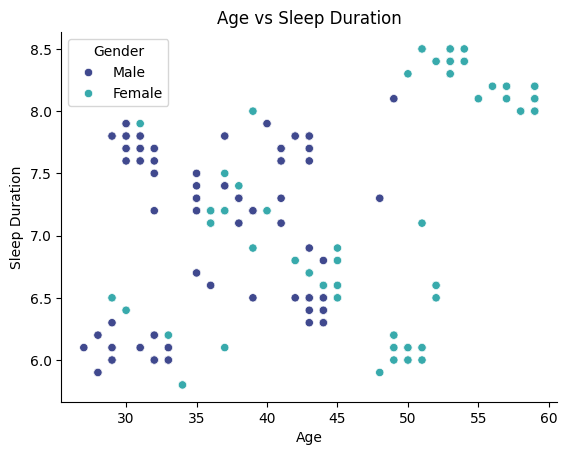

In [188]:
sns.scatterplot(data=df, x='Age', y='Sleep Duration', hue='Gender', palette="mako")
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Age vs Sleep Duration')

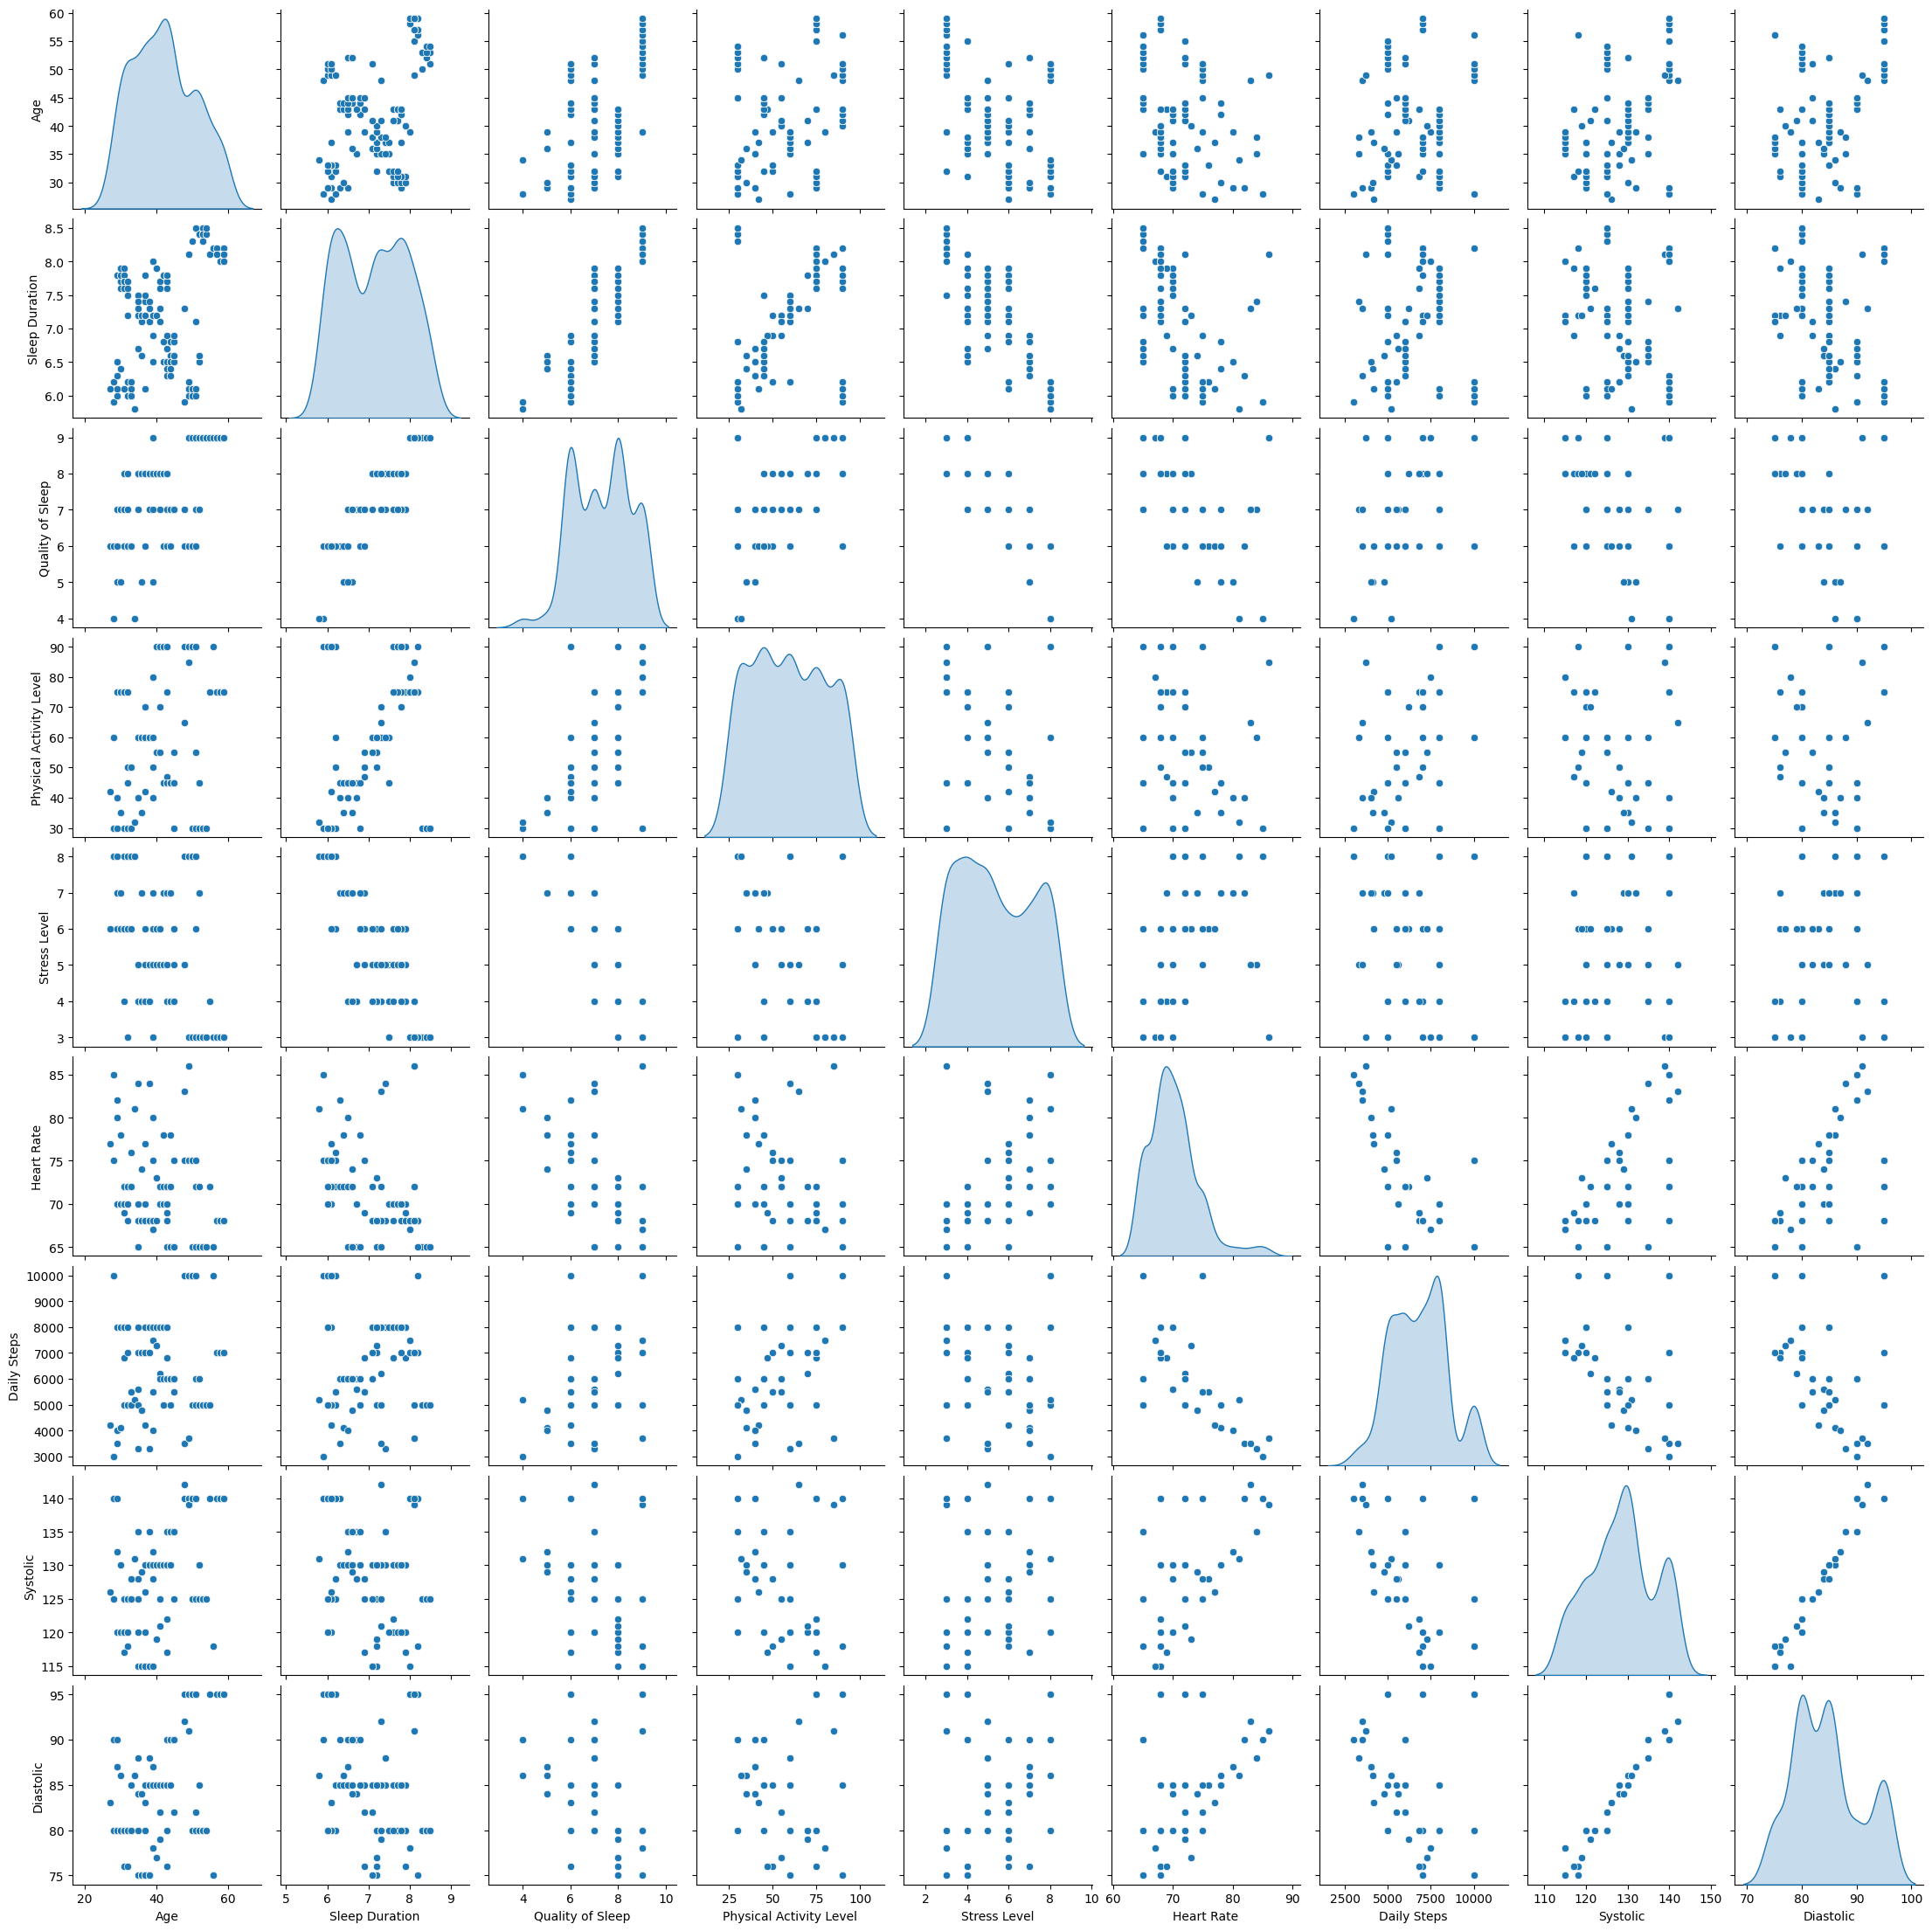

In [17]:
sns.pairplot(df, diag_kind="kde")

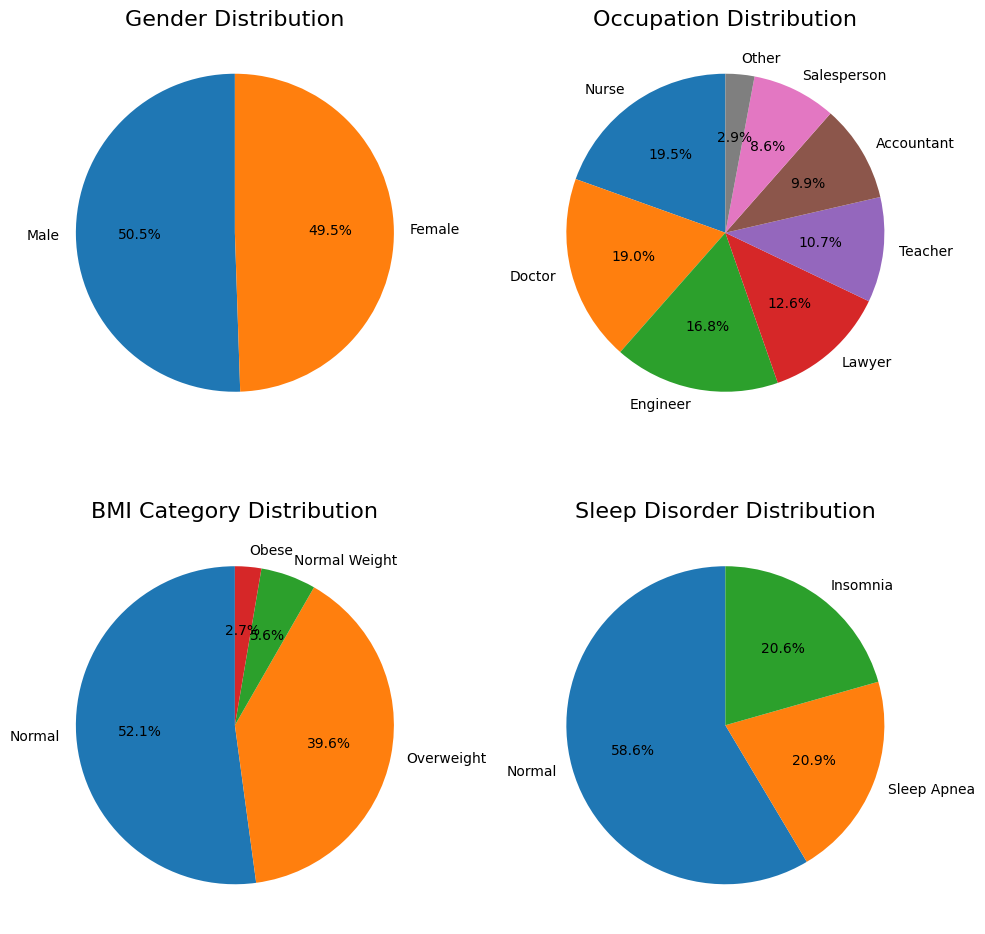

In [189]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Пол
gender_counts = df['Gender'].value_counts()
axes[0, 0].pie(gender_counts,
        labels=gender_counts.index,
        autopct='%1.1f%%',
        startangle=90)
axes[0, 0].set_title('Gender Distribution', fontsize=16)

# Профессия
occupation_counts = df['Occupation'].apply(lambda x:
                                           x if x not in ['Software Engineer', 'Scientist', 'Sales Representative', 'Manager'] else 'Other').value_counts()
occupation_counts.head()
axes[0, 1].pie(occupation_counts,
        labels=occupation_counts.index,
        autopct='%1.1f%%',
        startangle=90)
axes[0, 1].set_title('Occupation Distribution', fontsize=16)

# BMI
bmi_counts = df['BMI Category'].value_counts()
axes[1, 0].pie(bmi_counts,
        labels=bmi_counts.index,
        autopct='%1.1f%%',
        startangle=90)
axes[1, 0].set_title('BMI Category Distribution', fontsize=16)

# Расстройство сна
sleep_counts = df['Sleep Disorder'].value_counts()
axes[1, 1].pie(sleep_counts,
        labels=sleep_counts.index,
        autopct='%1.1f%%',
        startangle=90)
axes[1, 1].set_title('Sleep Disorder Distribution', fontsize=16)

plt.tight_layout()

plt.show()

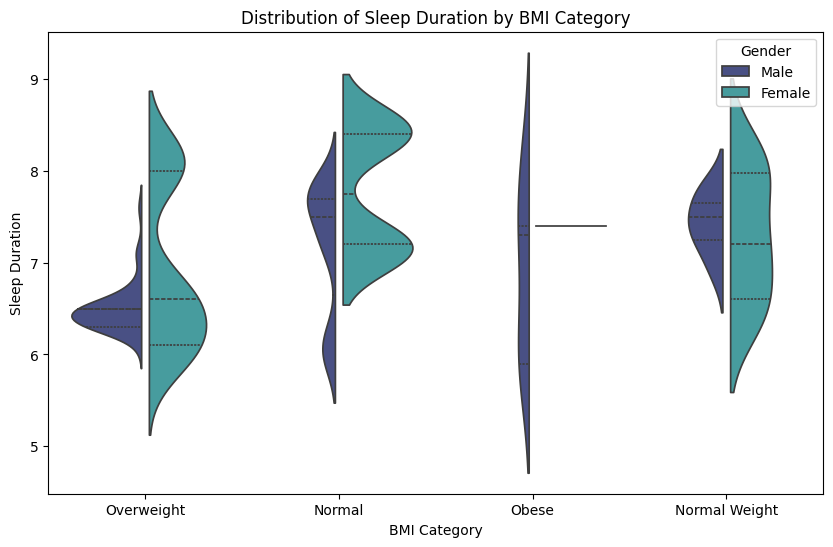

In [190]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="BMI Category", y="Sleep Duration", hue="Gender", palette = "mako", split=True, gap=.1, inner="quart")
plt.title('Distribution of Sleep Duration by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Sleep Duration')
plt.show()

In [191]:
def adjusted_boxplot_outlier_capping(data):
    # Вычисляем базовые статистики
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    med_couple = stattools.medcouple(data)

    # Определяем границы выбросов
    if med_couple > 0:
        lower_bound = q1 - 1.5 * np.exp(-3 * med_couple) * iqr
        upper_bound = q3 + 1.5 * np.exp(4 * med_couple) * iqr
    else:
        lower_bound = q1 - 1.5 * np.exp(-4 * med_couple) * iqr
        upper_bound = q3 + 1.5 * np.exp(3 * med_couple) * iqr

    # Приводим значения, выходящие за границы, к нижней или верхней границе
    capped_data = np.clip(data, lower_bound, upper_bound)

    return capped_data

In [192]:
num_data = df[['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']]

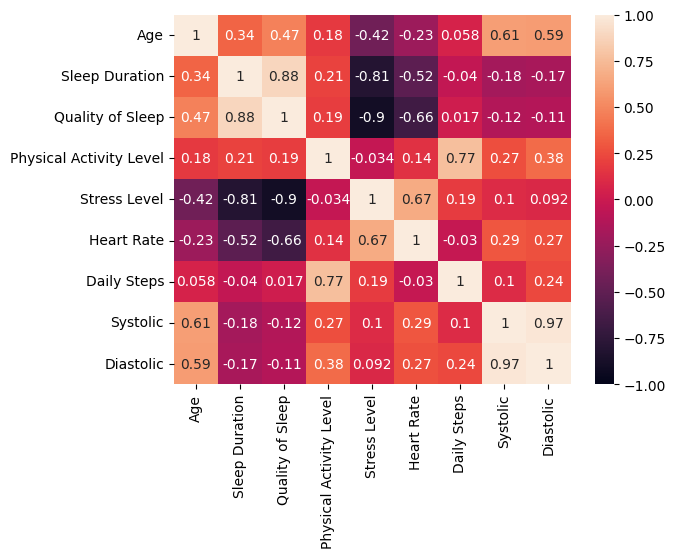

In [193]:
heatmap = sns.heatmap(num_data.corr(), vmin=-1, vmax=1, annot=True)

Используем минмакс, потому что распределение некоторых признаков бимодальное/мультимодальное

In [194]:
num_data.apply(adjusted_boxplot_outlier_capping)

scaler = MinMaxScaler()
normalized_num_data = pd.DataFrame(scaler.fit_transform(num_data), columns=['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic'])
normalized_num_data.index = range(1, len(normalized_num_data) + 1)

normalized_num_data

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic
1,0.00000,0.111111,0.4,0.20,0.6,0.571429,0.171429,0.407407,0.40
2,0.03125,0.148148,0.4,0.50,1.0,0.476190,1.000000,0.370370,0.25
3,0.03125,0.148148,0.4,0.50,1.0,0.476190,1.000000,0.370370,0.25
4,0.03125,0.037037,0.0,0.00,1.0,0.952381,0.000000,0.925926,0.75
5,0.03125,0.037037,0.0,0.00,1.0,0.952381,0.000000,0.925926,0.75
...,...,...,...,...,...,...,...,...,...
370,1.00000,0.851852,1.0,0.75,0.0,0.142857,0.571429,0.925926,1.00
371,1.00000,0.814815,1.0,0.75,0.0,0.142857,0.571429,0.925926,1.00
372,1.00000,0.851852,1.0,0.75,0.0,0.142857,0.571429,0.925926,1.00
373,1.00000,0.851852,1.0,0.75,0.0,0.142857,0.571429,0.925926,1.00


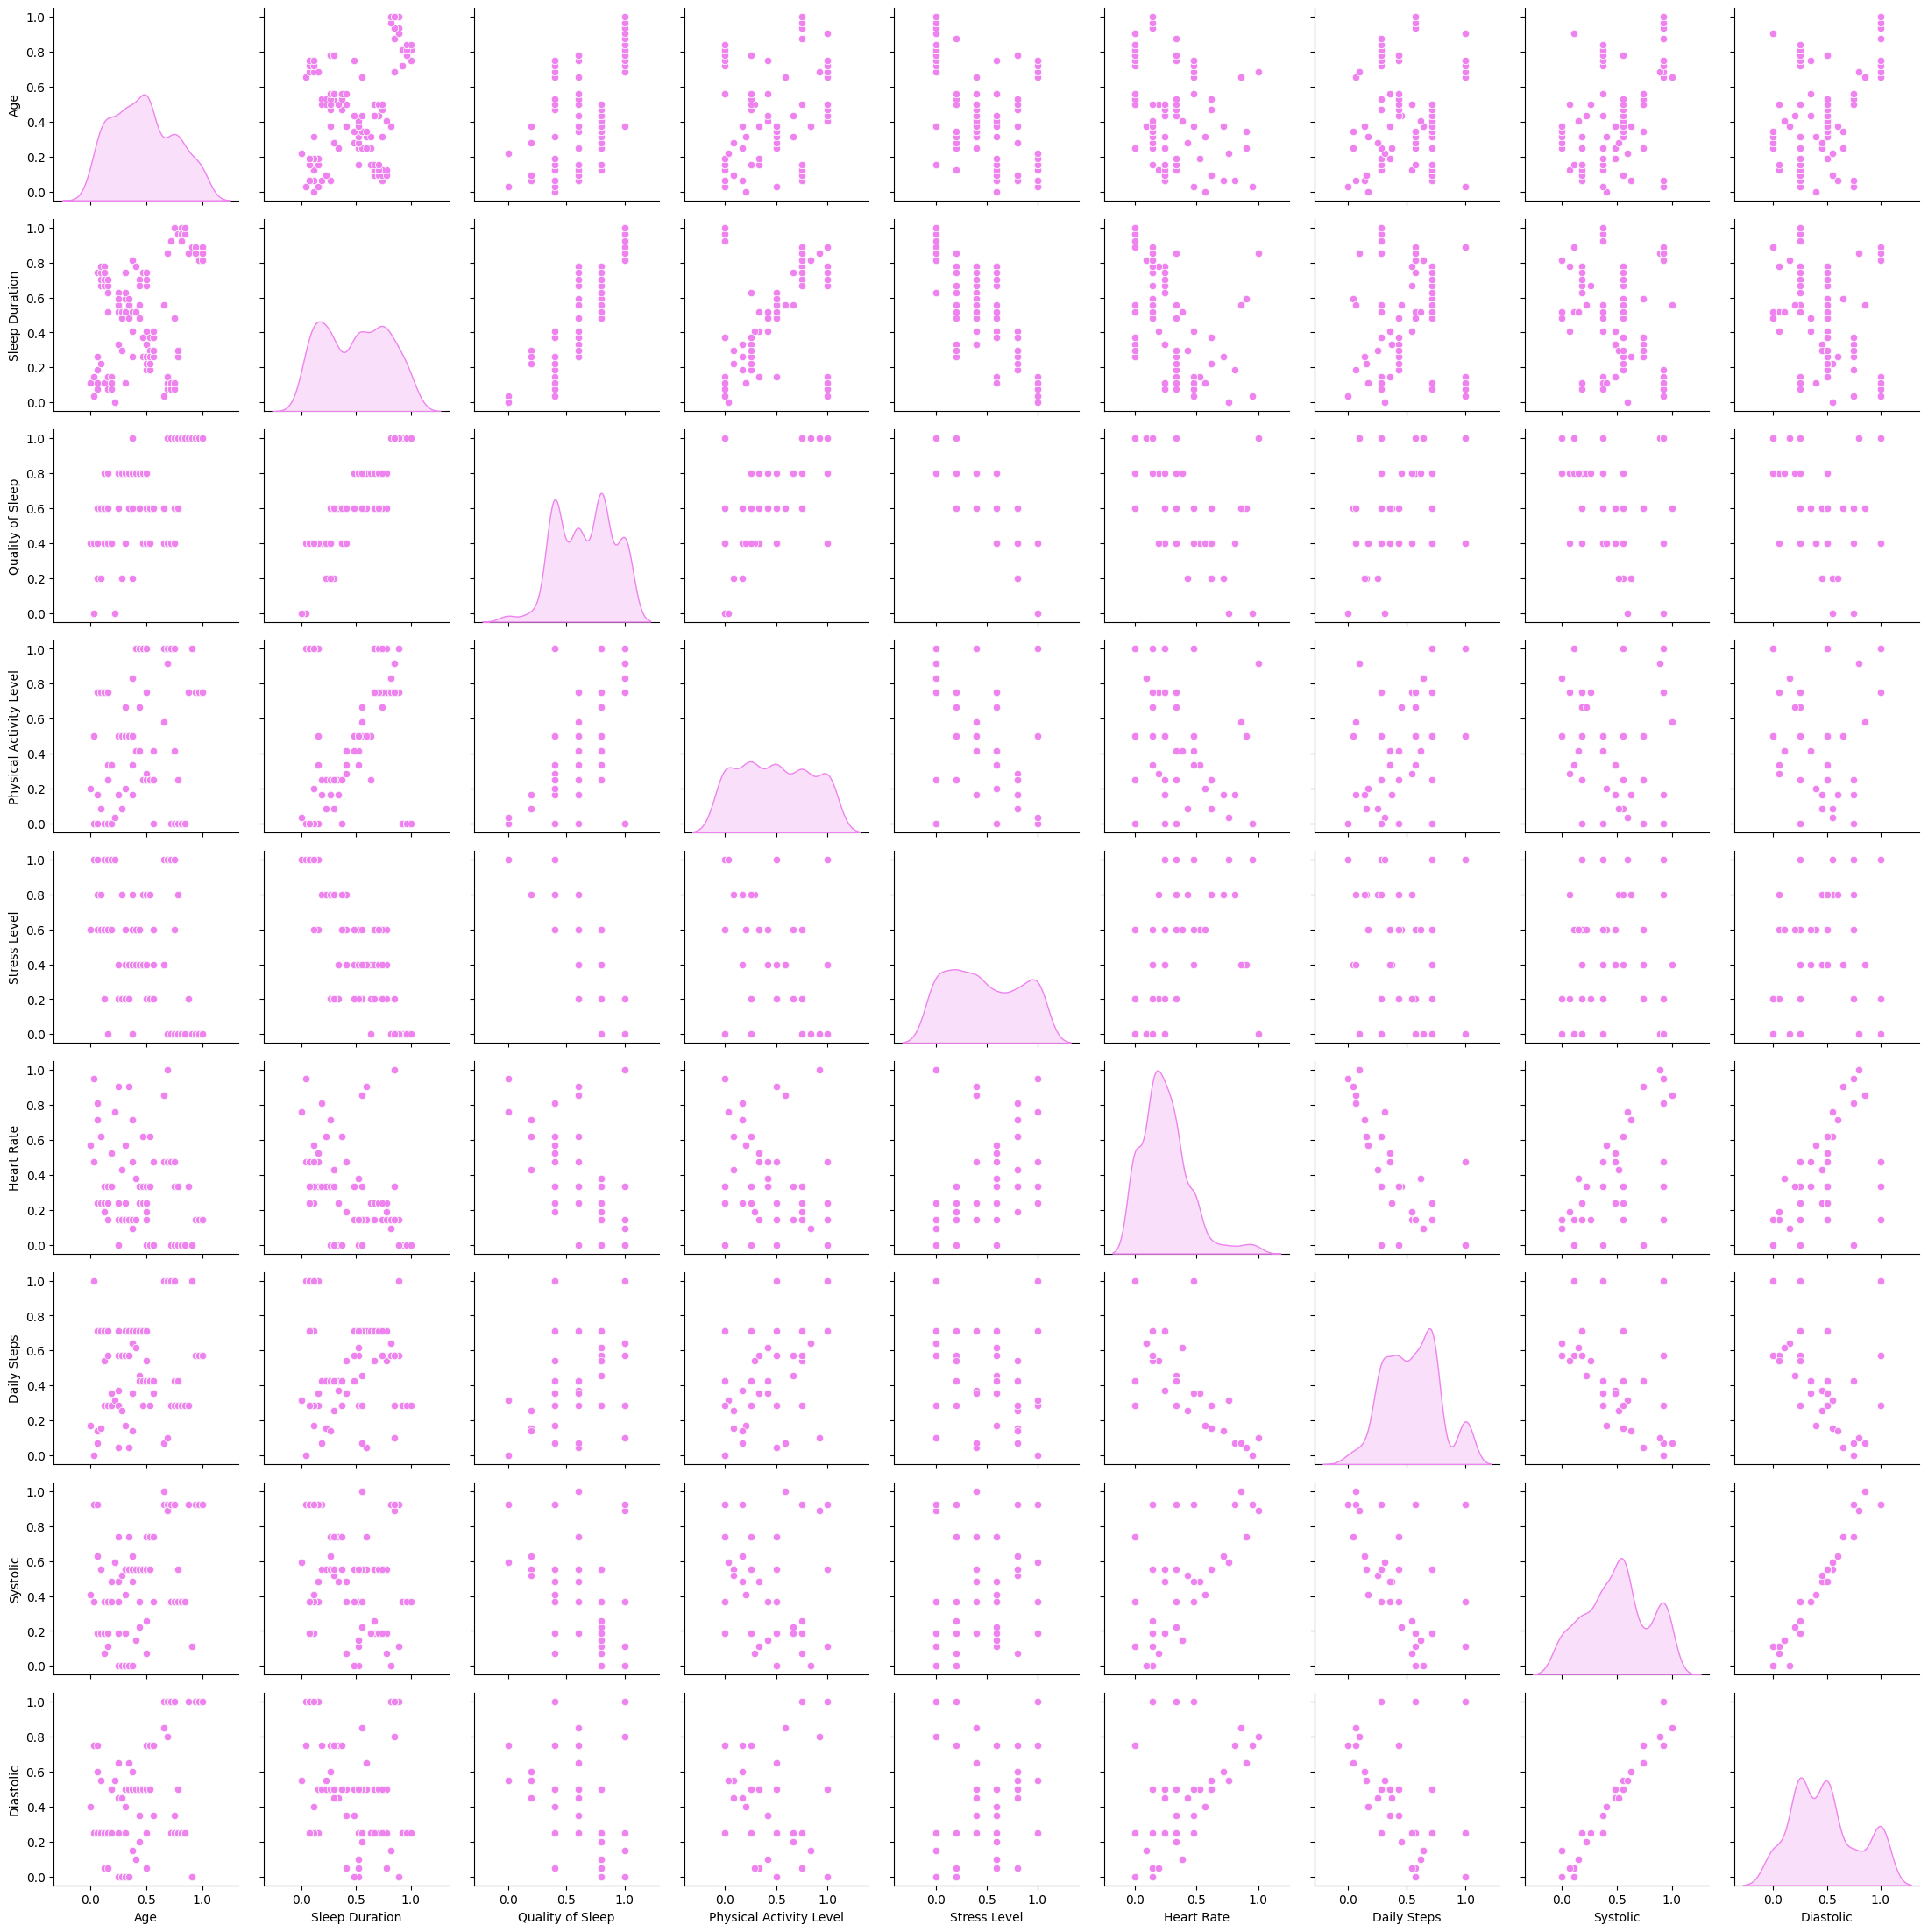

In [47]:
g = sns.PairGrid(normalized_num_data)
g.map_upper(sns.scatterplot,color='violet')
g.map_lower(sns.scatterplot, color='violet')
g.map_diag(sns.kdeplot, color='violet', fill=True)

In [195]:
cat_data = df[['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']]

In [196]:
encoded_cat_data = pd.get_dummies(cat_data[['Gender', 'BMI Category', 'Sleep Disorder']], drop_first=True)

le = LabelEncoder()
encoded_cat_data['Occupation_Encoded'] = le.fit_transform(cat_data['Occupation'])

encoded_cat_data.head()

,Gender_Male,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight,Sleep Disorder_Normal,Sleep Disorder_Sleep Apnea,Occupation_Encoded
Person ID,,,,,,,
1,True,False,False,True,True,False,9
2,True,False,False,False,True,False,1
3,True,False,False,False,True,False,1
4,True,False,True,False,False,True,6
5,True,False,True,False,False,True,6


In [197]:
preproc_data = pd.concat([normalized_num_data, encoded_cat_data], axis=1)
preproc_data.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender_Male,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight,Sleep Disorder_Normal,Sleep Disorder_Sleep Apnea,Occupation_Encoded
1,0.00000,0.111111,0.4,0.2,0.6,0.571429,0.171429,0.407407,0.40,True,False,False,True,True,False,9
2,0.03125,0.148148,0.4,0.5,1.0,0.476190,1.000000,0.370370,0.25,True,False,False,False,True,False,1
3,0.03125,0.148148,0.4,0.5,1.0,0.476190,1.000000,0.370370,0.25,True,False,False,False,True,False,1
4,0.03125,0.037037,0.0,0.0,1.0,0.952381,0.000000,0.925926,0.75,True,False,True,False,False,True,6
5,0.03125,0.037037,0.0,0.0,1.0,0.952381,0.000000,0.925926,0.75,True,False,True,False,False,True,6


## Кластеризация

### KMeans


In [246]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(preproc_data)
k_labels = kmeans.labels_
k_centroids = kmeans.cluster_centers_

df['KMeans Cluster'] = k_labels

In [352]:
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(preproc_data)
pd.DataFrame(data_pca).head()

,0,1
0,5.152056,-1.291279
1,-2.850635,-0.427872
2,-2.850635,-0.427872
3,2.279796,-0.174829
4,2.279796,-0.174829


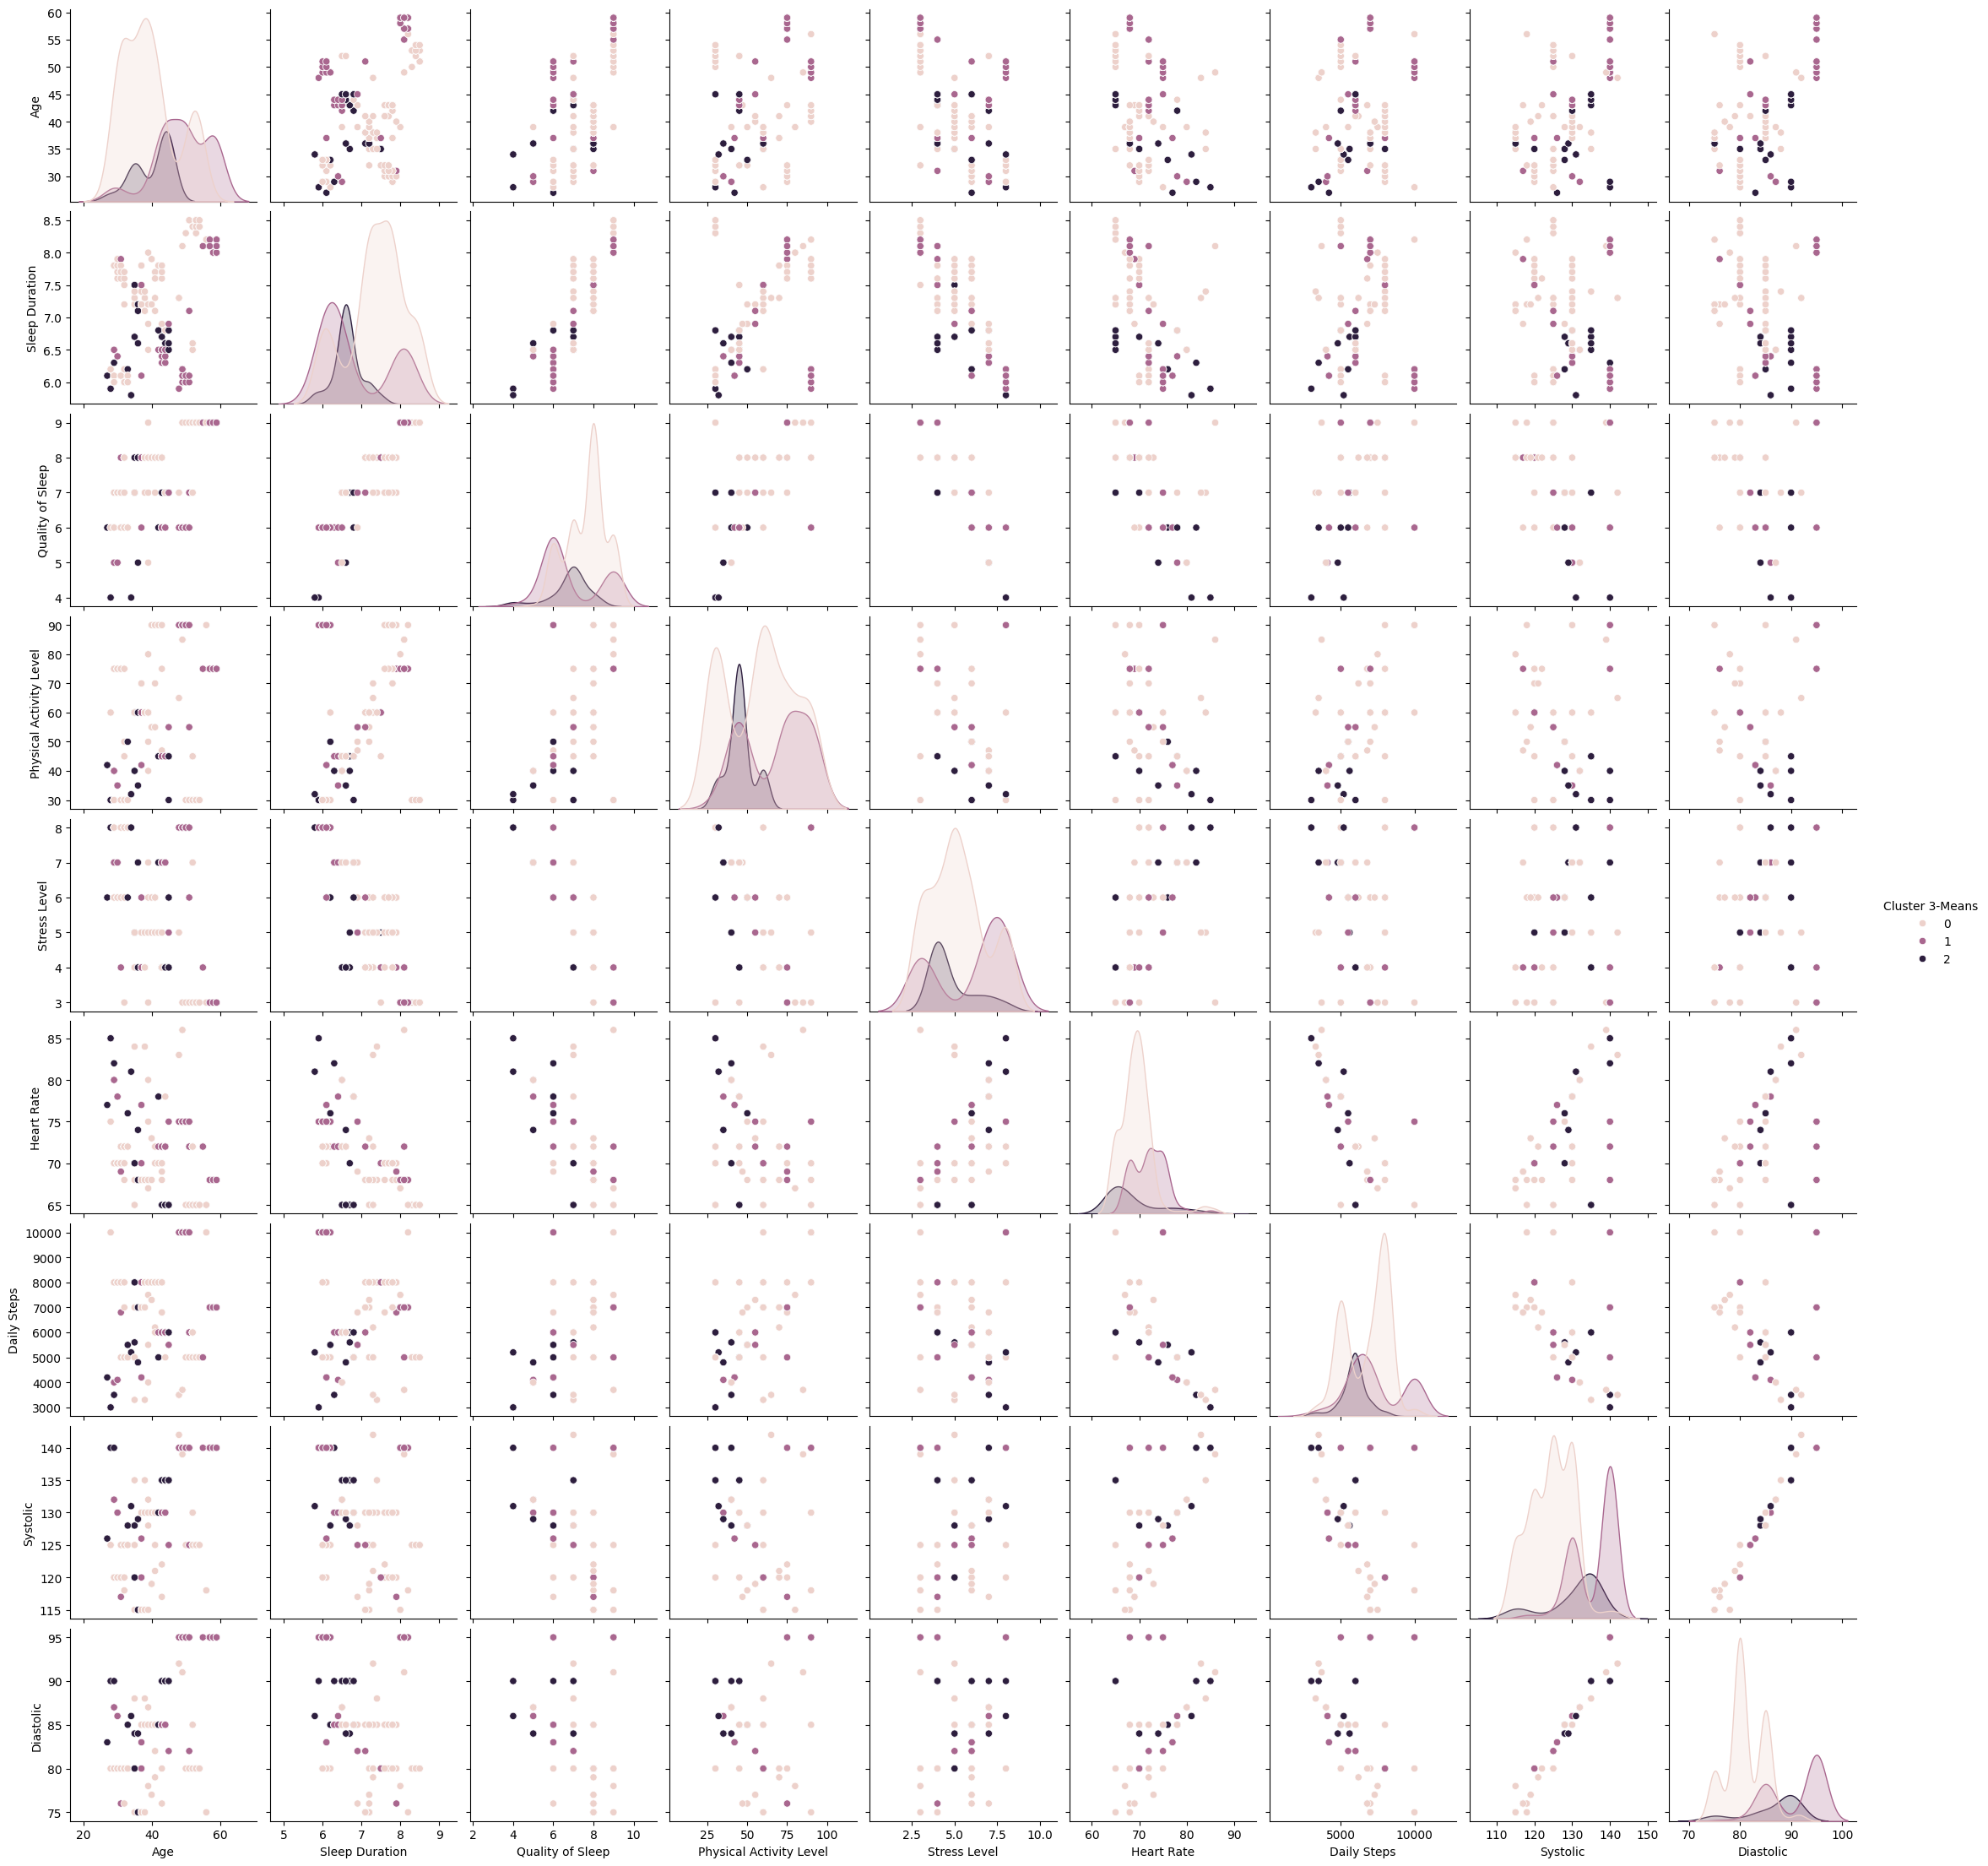

In [173]:
sns.pairplot(df, hue='Cluster 3-Means', diag_kind='kde')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


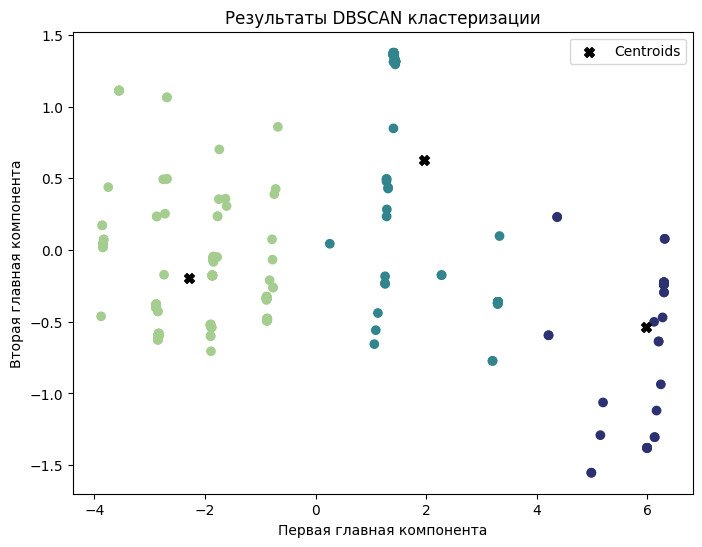

In [296]:
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=k_labels, cmap='crest')

centroids_pca = pca.transform(k_centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=50, c='black', marker='X', label='Centroids')

plt.title('Результаты DBSCAN кластеризации')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.legend()
plt.show()

### Иерархическая кластеризация

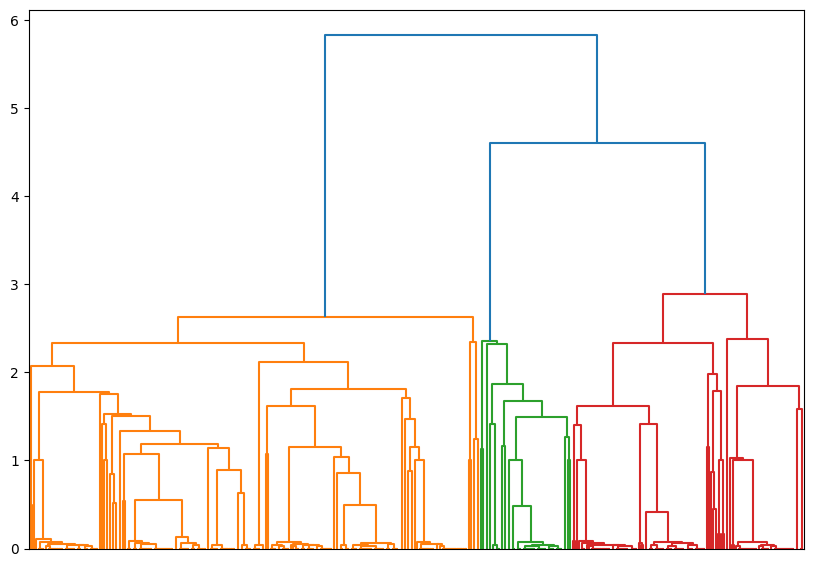

In [206]:
Z = linkage(preproc_data, method='average')
plt.figure(figsize=(10, 7))
dendrogram(Z, no_labels=True)
plt.show()

In [331]:
threshold_distance = 3.5

h_clusters = fcluster(Z, threshold_distance, criterion='distance') - 1
df['Hierarchy Cluster'] = h_clusters

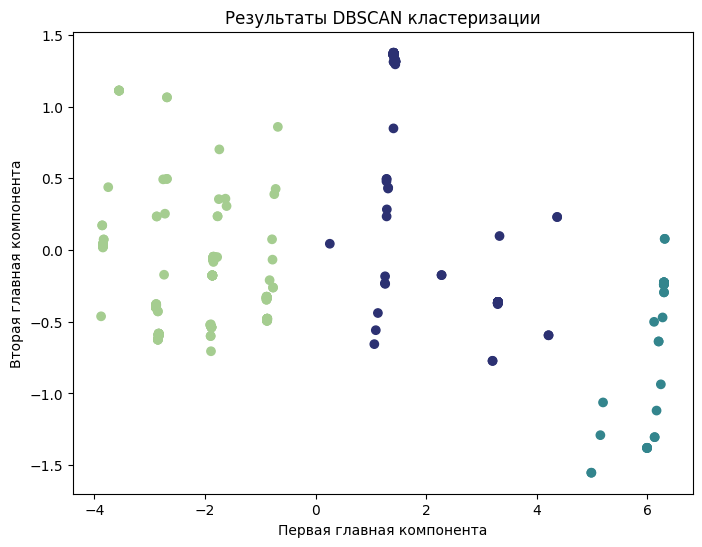

In [332]:
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=h_clusters, cmap='crest')

plt.title('Результаты DBSCAN кластеризации')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.show()

### DBSCAN

In [283]:
dbscan = DBSCAN(eps=2.2, min_samples=10)
dbscan.fit(preproc_data)
d_labels = dbscan.labels_
df['DBSCAN Cluster'] = d_labels

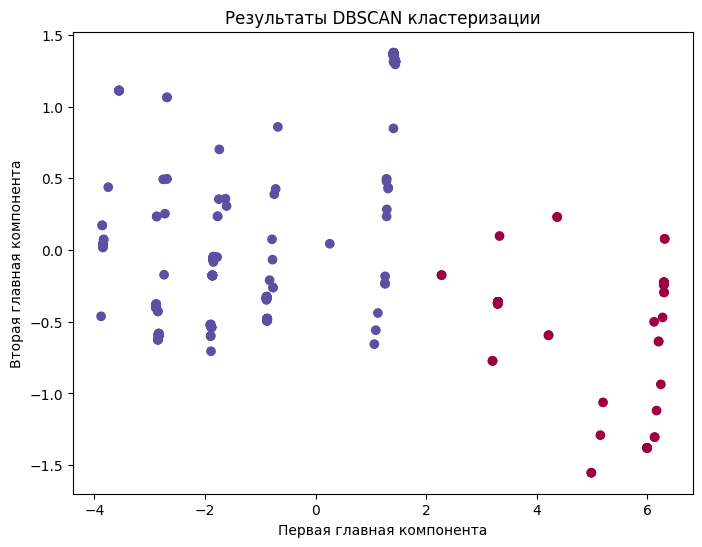

In [287]:
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=d_labels, cmap='Spectral')
plt.title('Результаты DBSCAN кластеризации')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.show()

### Сравнение методов

Для метода  KMeans Среднее значение коэффициента силуэта : 0.574669664057471
Для метода  Hierarchy Среднее значение коэффициента силуэта : 0.5764184118606859
Для метода  DBSCAN Среднее значение коэффициента силуэта : 0.5634282320691556


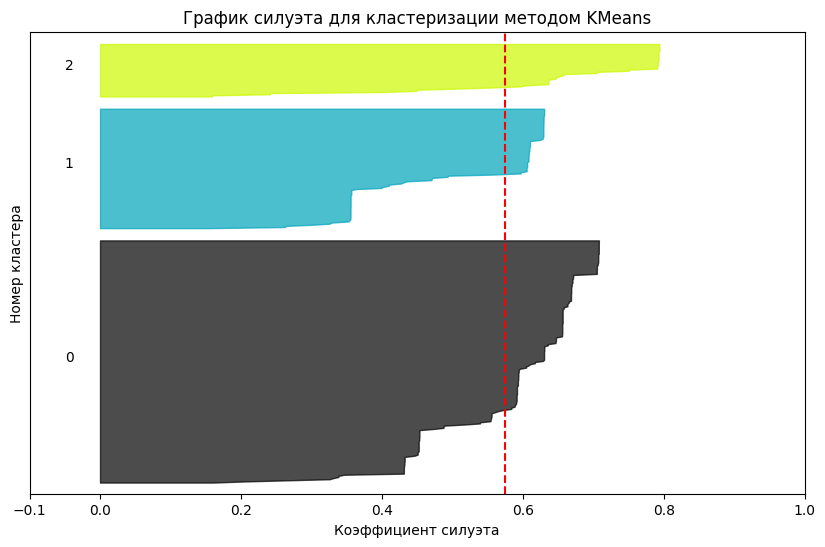

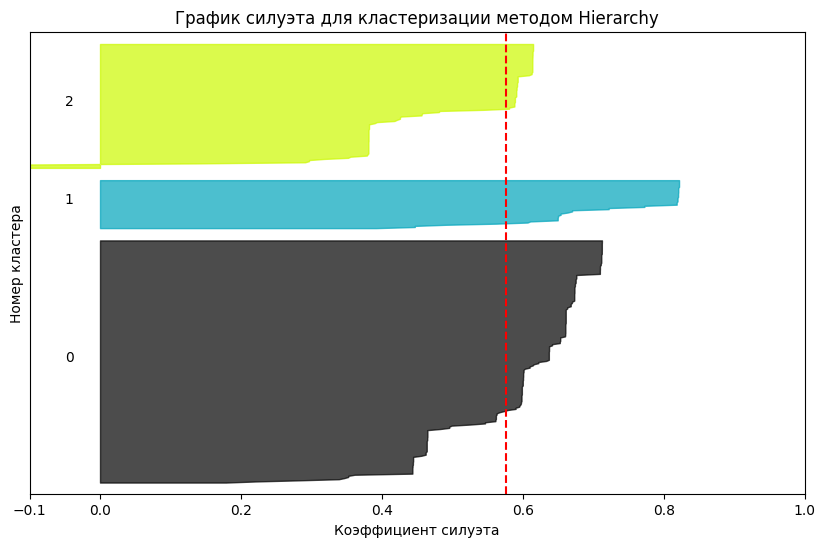

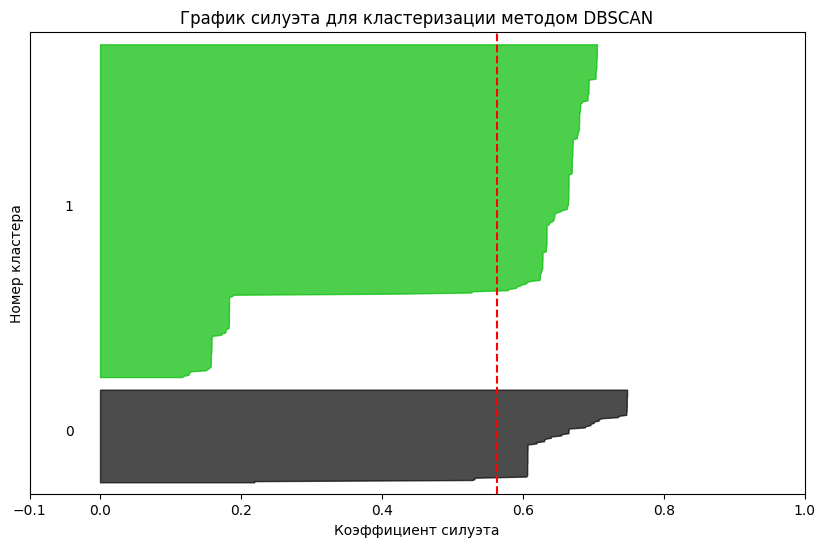

In [353]:
method_labels = [k_labels, h_clusters, d_labels]
method_names = ['KMeans', 'Hierarchy', 'DBSCAN']
X = preproc_data


for i in range(len(method_labels)):
  fig, (ax1) = plt.subplots(1, 1)
  fig.set_size_inches(10, 6)
  n_clusters = len(np.unique(method_labels[i]))

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  cluster_labels = method_labels[i]

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(X, cluster_labels)
  print(
      "Для метода ",
      method_names[i],
      "Среднее значение коэффициента силуэта :",
      silhouette_avg,
  )

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(X, cluster_labels)

  y_lower = 10
  for j in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster j, and sort them
      ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

      ith_cluster_silhouette_values.sort()

      size_cluster_j = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_j

      color = cm.nipy_spectral(float(j) / n_clusters)
      ax1.fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7,
      )

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title(f"График силуэта для кластеризации методом {method_names[i]}")
  ax1.set_xlabel("Коэффициент силуэта")
  ax1.set_ylabel("Номер кластера")

  # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


## Подбор гиперпараметров

### KMeans

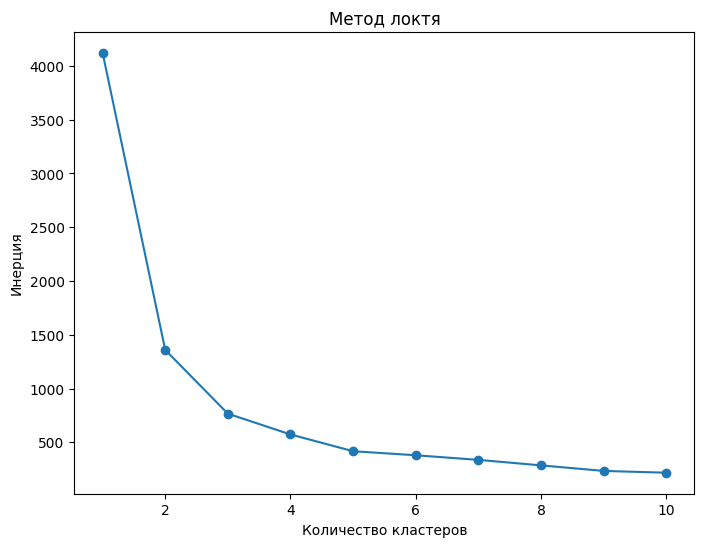

In [363]:
inertia = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(preproc_data)
  inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.show()


Для 2 кластеров Среднее значение коэффициента силуэта : 0.5634282320691556

Для 3 кластеров Среднее значение коэффициента силуэта : 0.574669664057471


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(



Для 4 кластеров Среднее значение коэффициента силуэта : 0.4423688163089067

Для 5 кластеров Среднее значение коэффициента силуэта : 0.46589243137929065


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(



Для 6 кластеров Среднее значение коэффициента силуэта : 0.5172567768301641


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


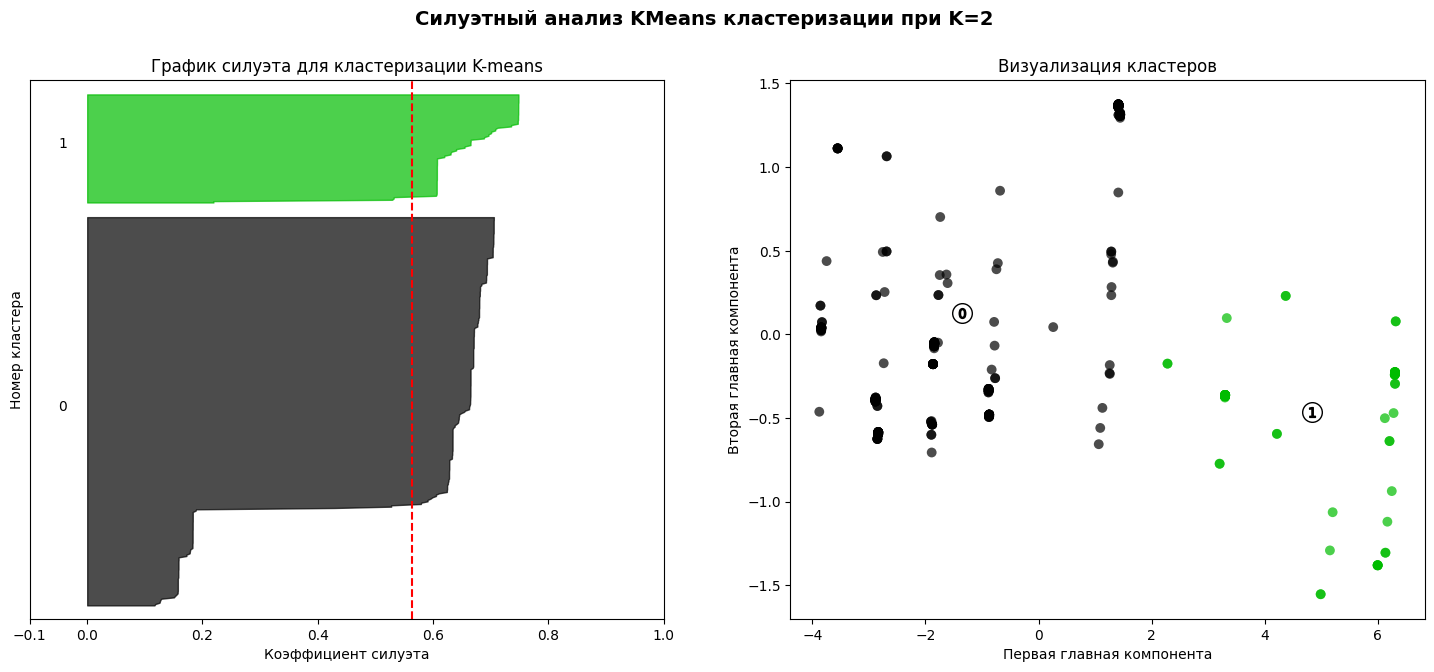

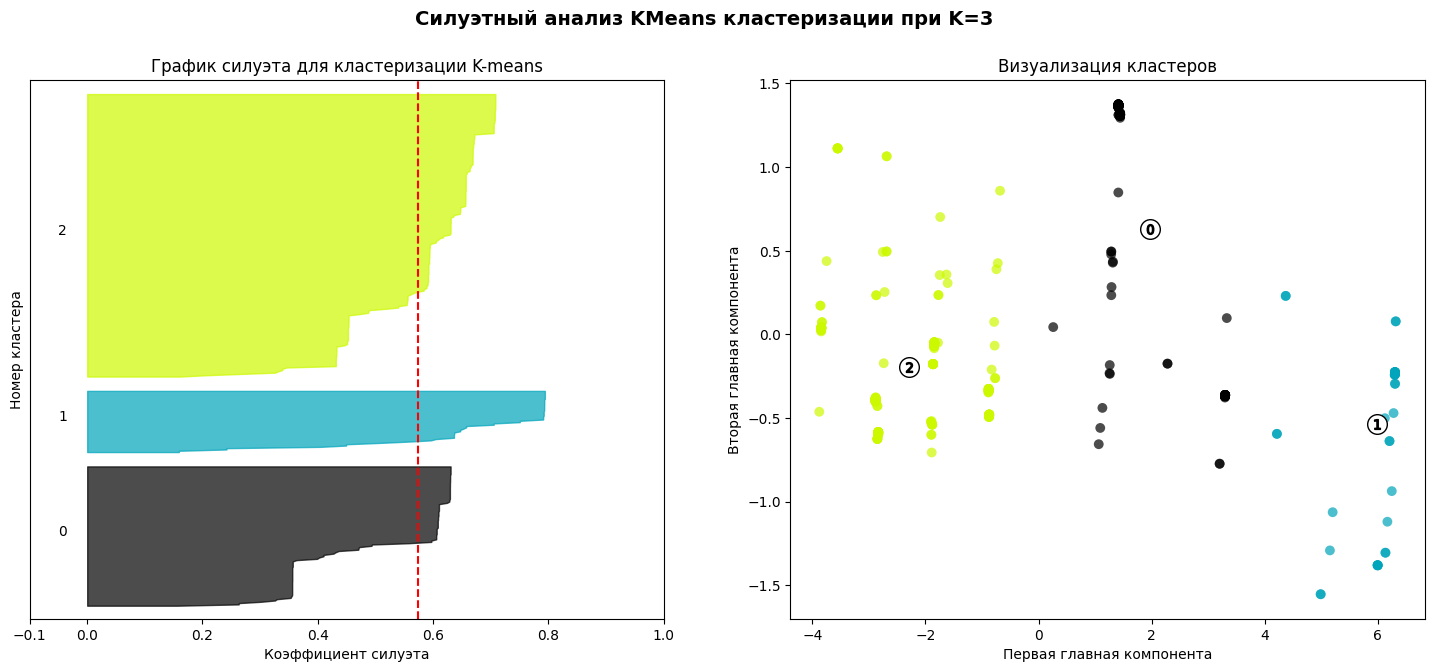

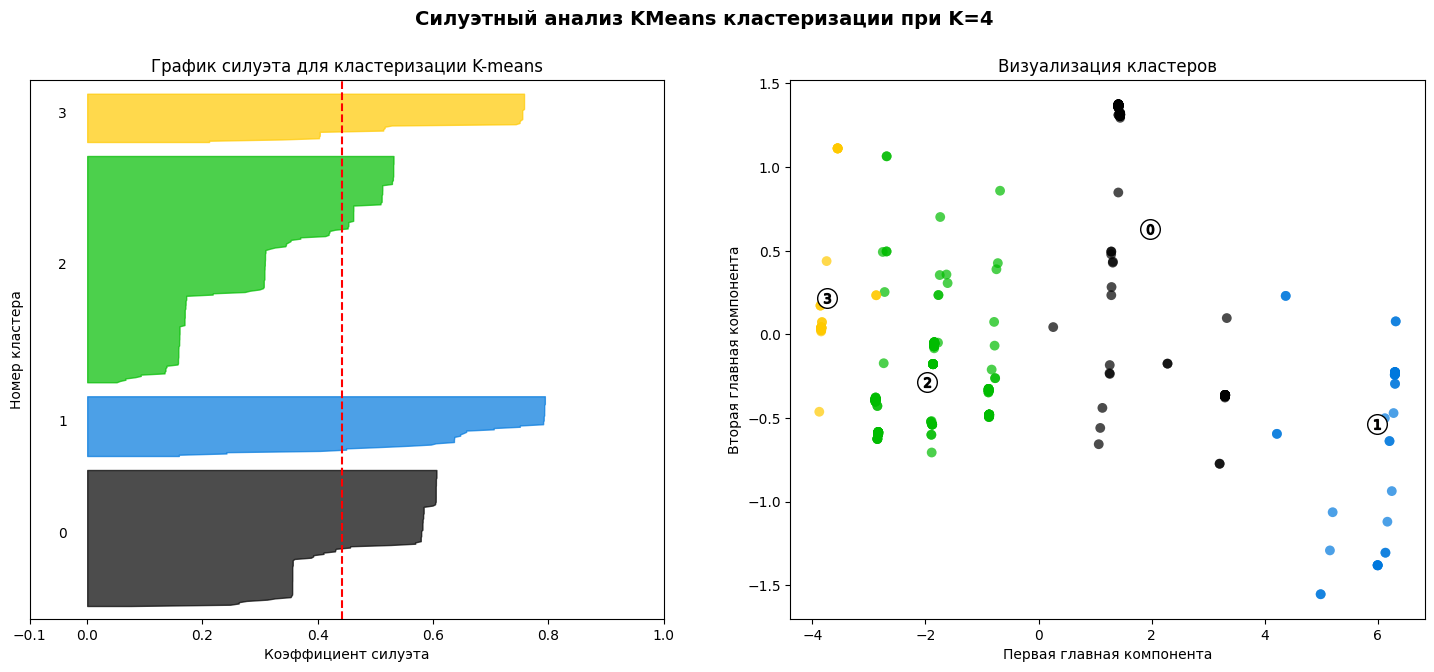

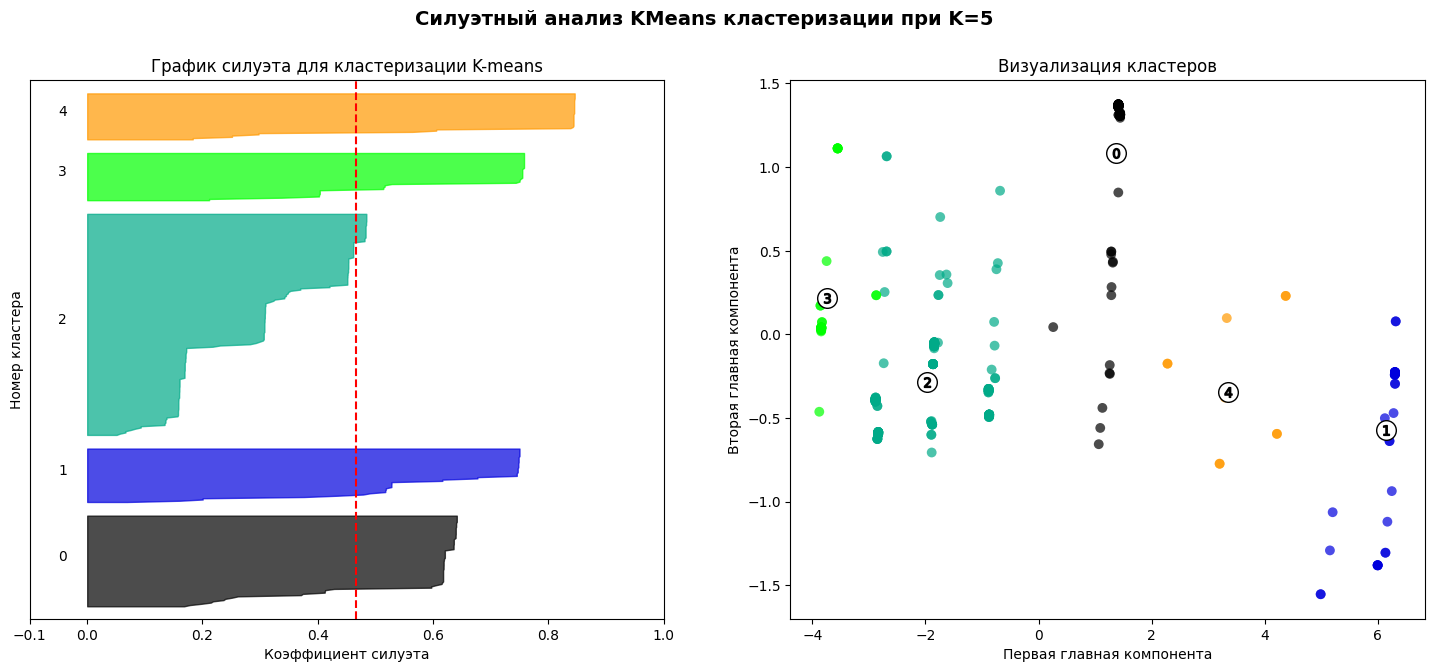

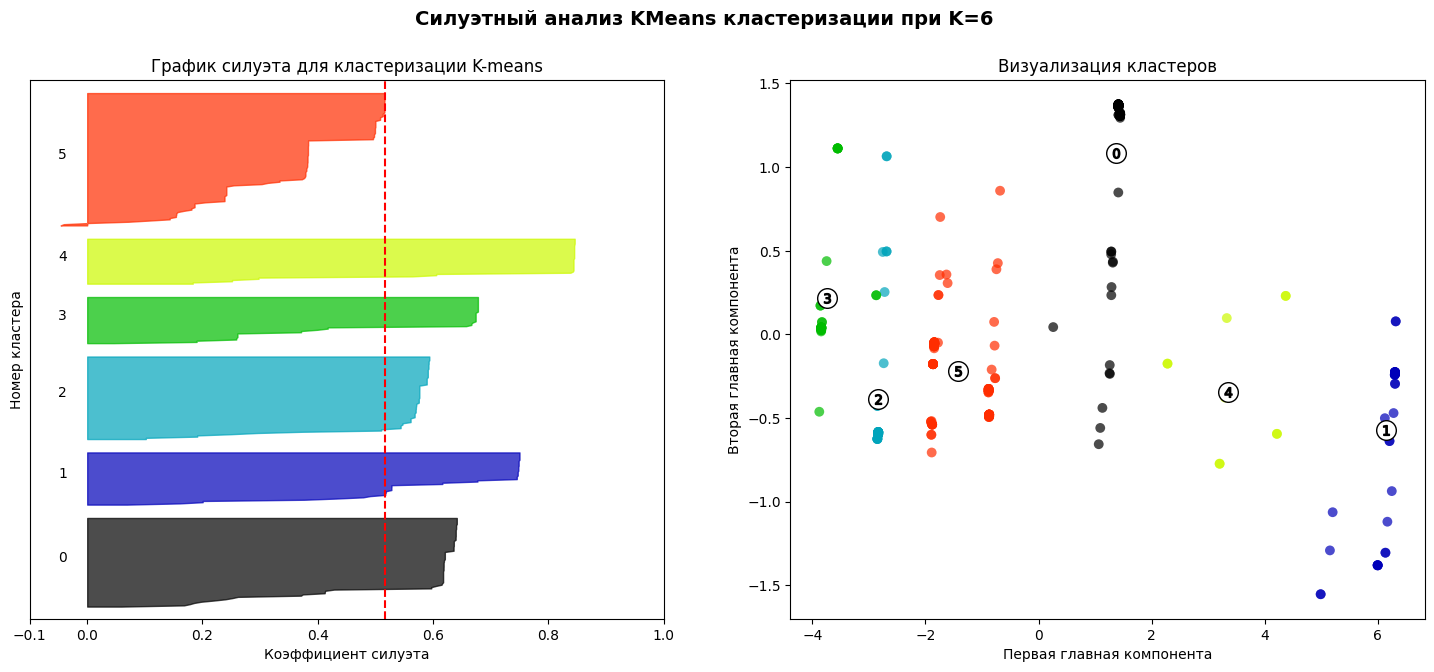

In [361]:
range_n_clusters = [2, 3, 4, 5, 6]
X = preproc_data

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(preproc_data)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        f"\nДля {n_clusters} кластеров",
        "Среднее значение коэффициента силуэта :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("График силуэта для кластеризации K-means")
    ax1.set_xlabel("Коэффициент силуэта")
    ax1.set_ylabel("Номер кластера")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_pca[:, 0], X_pca[:, 1], marker=".", s=200, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = pca.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    plt.title('Визуализация кластеров')
    plt.xlabel('Первая главная компонента')
    plt.ylabel('Вторая главная компонента')

    plt.suptitle(
        f"Силуэтный анализ KMeans кластеризации при K={n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Оптимально использовать K=3

### Иерархическая кластеризация

### DBSCAN